# Dynamic Aperture fitting and extrapolation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import sixdesk.da as da
import sixdesk.dist as dist
from sixdesk.da import davst_function, get_fitting_params_distribution, beamloss, get_da_from_fit_output

bl = beamloss()  # load the module to calculate the beam loss

## Perform the fitting

### Standard fitting procedure
With an existing study load the da vs turn and run the fitting algorithm. In the simplest case when all seeds should be included, the fit is not to be performed angle by angle and the range of kappas should be the default one 

$$ -5 \leq \kappa \leq 5 $$

with a step size of $\Delta \kappa = 0.1$, we can simply use the davst.fit() method without any arguments. The davst class must be initialized with a path to the database file to be studied and the emittance to be considered (note that if the emittance used can differ from the one used in the sixdeskenv, the DA values will be scaled accordingly).

In [3]:
dbname = '/home/phermes/development/SixDeskDB/chrom-20.0-40.0.db'
a = da.davst(dbname,2.2)
a.fit()

The fitting parameters and their uncertainties are stored in

In [4]:
a.fit_params.head()

,seed,angle,emit,d,b,k,chi,derr,berr
0,1,None,2.2,4.306541,162.044181,2.9,0.086606,0.003223,6.114471
1,2,None,2.2,5.307757,575.217596,4.3,0.050841,0.000960,78.250343
2,3,None,2.2,5.431677,913.708419,4.9,0.071171,0.001305,421.418351
3,4,None,2.2,4.043215,260.685354,3.2,0.221649,0.010747,46.979399
4,5,None,2.2,5.376183,1054.334139,4.7,0.086848,0.001886,395.342439


We can now extrapolate the DA for a desired time using

In [5]:
a.get_extrapolated_da(minutes=30)

The result will be stored in

In [6]:
a.extrapolated_da.head()

,seed,angle,emit,d,b,k,chi,derr,berr,exda_1800_sec
0,1,None,2.2,4.306541,162.044181,2.9,0.086606,0.003223,6.114471,4.813437
1,2,None,2.2,5.307757,575.217596,4.3,0.050841,0.000960,78.250343,5.418916
2,3,None,2.2,5.431677,913.708419,4.9,0.071171,0.001305,421.418351,5.485220
3,4,None,2.2,4.043215,260.685354,3.2,0.221649,0.010747,46.979399,4.492264
4,5,None,2.2,5.376183,1054.334139,4.7,0.086848,0.001886,395.342439,5.468146


Every time the method get_extrapolated_da will be called with an un-stored extrapolation time, the DataFrame will be extended.

We can also compare the fit to the raw data 

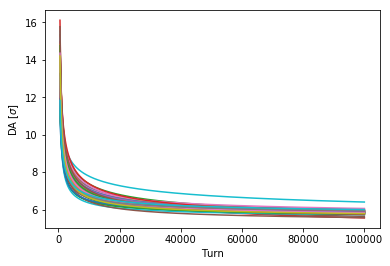

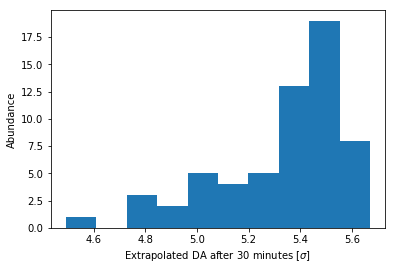

In [7]:
turn = np.arange(500,100000)
for row in a.extrapolated_da.iterrows():
    d, b, k = row[1]['d'], row[1]['b'], row[1]['k']
    plt.plot(turn, davst_function(turn,d,b,k))
plt.xlabel("Turn")
plt.ylabel(r"DA [$\sigma$]")
plt.show()

plt.hist(a.extrapolated_da['exda_1800_sec'])
plt.xlabel(r"Extrapolated DA after 30 minutes [$\sigma$]")
plt.ylabel("Abundance")
plt.show()

Or we can look at the data and the fit for a given seed

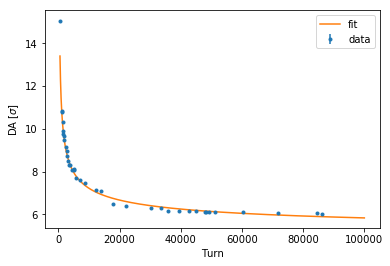

In [8]:
fitp = a.fit_params.iloc[0]

data = a.clean_data_for_seed(1)
plt.errorbar(data['nturnavg'], data['dawsimp'], yerr=data['dawsimperr'],fmt='.',label='data')
turn = np.arange(500,100000)
plt.plot(turn, davst_function(turn, fitp['d'],fitp['b'],fitp['k']),label='fit')
plt.legend()
plt.xlabel("Turn")
plt.ylabel(r"DA [$\sigma$]")
plt.show()

### Options for the fitting
Several options are available to refine the fitting or to take into account special cases.

In [35]:
dbname = '/home/phermes/development/SixDeskDB/chrom-20.0-40.0.db'
a = da.davst(dbname,2.2)

#### Select a range of seeds
If only certain seeds should be used, the fit method can be called with the option seed. The optional argument must be iterable.

In [4]:
a.fit(seeds=[1,2,34])

In [5]:
a.fit_params

,seed,angle,emit,d,b,k,chi,derr,berr
0,1,None,2.2,4.306541,162.044181,2.9,0.086606,0.003223,6.114471
1,2,None,2.2,5.307757,575.217596,4.3,0.050841,0.000960,78.250343
2,34,None,2.2,5.210577,1412.924274,4.9,0.061667,0.001022,605.703387


#### Select a range of possible values for kappa

If $\kappa$ shall be in a certain range, or if the granularity of the scan in $\kappa$ shall be increased, we can call the davst.fit() method with an argument indicating the minimum, maximum $\kappa$ and the step size. E.g. assume we want to fit with a step size of 0.01 instead of 0.1 and scan from 2.8 to 3.0, we can use:

In [8]:
a.fit(kappas=[2.8,3.0,0.01])

In [9]:
a.fit_params.head()

,seed,angle,emit,d,b,k,chi,derr,berr
0,1,None,2.2,4.272505,157.412344,2.87,0.086558,0.003269,5.757188
1,2,None,2.2,4.534872,151.554849,3.00,0.101692,0.003192,10.299138
2,3,None,2.2,4.625967,123.726822,3.00,0.194156,0.007310,21.186430
3,4,None,2.2,3.805237,213.863199,3.00,0.222930,0.011775,31.099468
4,5,None,2.2,4.248226,179.840541,3.00,0.193157,0.007052,21.127683


#### Select integration method
By default the davst class uses the DA calculated via integration using the weighted Simpson method (dawsimp). We can use other columns as well, e.g. dawtrap (using the trapezoidal rule). Note that both DA and DA error column must be adapted.

In [12]:
a.fit(dacol='dawtrap', daerrcol='dawtraperr')

#### Specify the horizontal axis

By default nturnavg (the mean between tlossmin and nturn) is used. We can alternatively use tlossmin or nturn istead:

In [13]:
a.fit(xaxis='nturn')

#### Save the fit parameters in the database
The fit parameters can be directly saved into the SixDeskDB (table name: *fit_params*) and will be automatically loaded to davst.fit_params when the davst class is initialized next time.

In [36]:
a.fit(save=True)

## Include the fitting error to define a set of realistic cases

We can now use the errors from the fitting and assume that the real value for d and b is normally distributed around the main value with the diagonal entries of the covariance matrix being the square of the standard deviation. Instead of using only the 60 seed we can produce alternatives by randomly sampling values for D and b with the aforementioned assumption. Let's produce 1000 realizations for each seed. Resulting in a total of 60000 fitting parameters to consider.

In [5]:
a.get_extrapolated_da(minutes=30, realizations=1000)
a.get_extrapolated_da(minutes=60)
a.get_extrapolated_da(minutes=120)
a.get_extrapolated_da(minutes=240)
a.get_extrapolated_da(minutes=480)

In [13]:
len(a.extrapolated_da)

60000

The extrapolated DA values for each realization are now stored in a.extrapolated_da

In [14]:
a.extrapolated_da.head()

,seed,angle,emit,d,b,k,chi,derr,berr,exda_1800_sec,exda_3600_sec,exda_7200_sec,exda_14400_sec,exda_28800_sec
0,1,None,2.2,4.310746,162.139711,2.9,0,0,0,4.817941,4.761899,4.713877,4.672485,4.636611
1,1,None,2.2,4.306586,155.753432,2.9,0,0,0,4.793804,4.739969,4.693839,4.654077,4.619617
2,1,None,2.2,4.306000,148.949555,2.9,0,0,0,4.771935,4.720452,4.676336,4.638311,4.605357
3,1,None,2.2,4.304794,158.300786,2.9,0,0,0,4.799981,4.745266,4.698381,4.657969,4.622945
4,1,None,2.2,4.301383,148.828923,2.9,0,0,0,4.766940,4.715499,4.671419,4.633425,4.600497


The extrapolated DA can (and should!) be also saved to the database. We can do so by using the save option. In full analogy to the fit method, the extrapolated DA table will be automatically loaded from the database when davst is initialized for the db next time.

In [ ]:
a.get_extrapolated_da(minutes=30, save=True)

## Evolution of the DA with increasing turn numbers

In [41]:
for time in [1,10,100,1000,10000]:
    a.get_extrapolated_da(seconds=time)

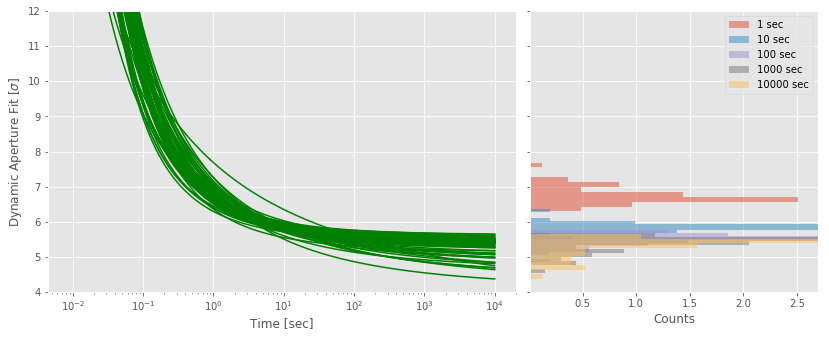

In [44]:
from matplotlib.ticker import NullFormatter

fig = plt.figure(figsize=[10,6])
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.style.use('ggplot')

nullfmt = NullFormatter()         # no labels

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histy = [left_h, bottom, 0.4, height]

axdavst = plt.axes(rect_scatter)
axHisty = plt.axes(rect_histy)

axHisty.yaxis.set_major_formatter(nullfmt)


#### ANALYSIS PART

for i in range(0,60):
    d,b,k = a.fit_params[['d','b','k']].iloc[i]
    turns = np.arange(10000, a.revf*10000,1000)
    times = turns/a.revf
    axdavst.plot(times,davst_function(turns,d,b,k), 'g-', label='Fit')
    turns = np.arange(100,10000)
    times = turns/a.revf
    axdavst.plot(times,davst_function(turns,d,b,k), 'g-')

for time in [1,10,100,1000,10000]:
    axHisty.hist(a.extrapolated_da['exda_{0}_sec'.format(time)],
                 bins=10,alpha=0.5,label='{0} sec'.format(time), orientation='horizontal',normed=True)
    
# for j in range(3,8):
#     axHisty.hist(ex_da[j],bins=10,alpha=0.5,label='1e{0} turns'.format(j), orientation='horizontal',normed=True)

# axdavst.set_xlim(1e2,a.revf*3600)
axdavst.set_ylim(4,12)

axHisty.set_xlabel("Counts")
axHisty.set_xlim(0.01,2.7)
axHisty.set_ylim(axdavst.get_ylim())

axdavst.set_xscale('log')
axHisty.legend()
axdavst.set_xlabel("Time [sec]")
axdavst.set_ylabel(r"Dynamic Aperture Fit [$\sigma$]")

# for i in range(3, 4):
#     axdavst.plot([10**i, 1e8], [np.min(ex_da[i]), np.min(ex_da[i])], 'k--', lw=1)
#     axdavst.plot([10**i, 1e8], [np.max(ex_da[i]), np.max(ex_da[i])], 'k--', lw=1)

axdavst.grid(which='b')
plt.show()


## Calculation of Beam Loss
With the fitting parameters we can use the loss_from_fit_params method of the beamloss class to get the distribution of possible beam loss:

In [48]:
loss       = bl.loss_from_fit_params(a.fit_params, time=12*60*60)

In [55]:
len(loss)

89520

If we want to use the different realizations we have to use the a.extrapolated_da DataFrame.

In [57]:
a.get_extrapolated_da(minutes=30,realizations=1000)

In [58]:
loss       = bl.loss_from_fit_params(a.extrapolated_da, time=12*60*60)

In [59]:
loss

array([ 0.00552972,  0.00657851,  0.00768723, ...,  0.00728384,
        0.00708151,  0.00720487])

In [60]:
len(loss)

89520000

In [61]:
pd.Series(loss).describe()

count    8.952000e+07
mean     6.840857e-03
std      2.043335e-03
min      1.558510e-03
25%      5.384390e-03
50%      6.874820e-03
75%      8.153360e-03
max      1.605730e-02
dtype: float64

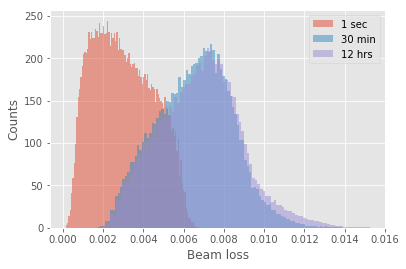

In [63]:
loss       = bl.loss_from_fit_params(a.fit_params, time=1)
plt.hist(loss,bins=100,normed=True, label='1 sec',alpha=0.5)

loss       = bl.loss_from_fit_params(a.fit_params, time=30*60)
plt.hist(loss,bins=100,normed=True, label='30 min', alpha=0.5)

loss       = bl.loss_from_fit_params(a.fit_params, time=12*60*60)
plt.hist(loss,bins=100,normed=True, label='12 hrs',alpha=0.5)

plt.legend()
plt.xlabel("Beam loss")
plt.ylabel("Counts")
plt.show()

Instead of computing new fit parameters with the different realizations, the loss_from_fit_params method allows to parse the number of realizations directly. In that case we can skip the step of calculating the different realizations of the fit_parameters beforehand. Of course now we use the fit parameters for the individiual seeds now: a.fit.

In [64]:
loss       = bl.loss_from_fit_params(a.fit_params, time=12*60*60, realizations=1000)

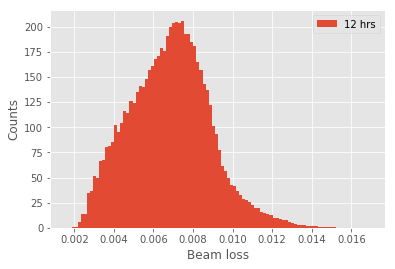

In [65]:
plt.hist(loss,bins=100,normed=True, label='12 hrs')

plt.legend()
plt.xlabel("Beam loss")
plt.ylabel("Counts")
plt.show()

Check how long it takes to calculate the beam loss for different realizations

In [68]:
import time
for realizations in [1, 10, 100, 200, 500, 1000]:
    t0 = time.time()
    loss       = bl.loss_from_fit_params(a.fit_params, time=12*60*60, realizations=realizations)
    print("{0} Realizations: {1} seconds".format(realizations,time.time()-t0))

1 Realizations: 0.04655098915100098 seconds
10 Realizations: 0.08280754089355469 seconds
100 Realizations: 0.6537742614746094 seconds
200 Realizations: 1.618330717086792 seconds
500 Realizations: 3.50390887260437 seconds
1000 Realizations: 8.457242727279663 seconds
